# NISAR Cryosphere ATBD Code Examples and Documentation
---

In [62]:
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
from urllib import request
from gimpfunc import NASALogin
import matplotlib.pyplot as plt
import panel
from datetime import datetime
panel.extension() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Login for Remote Access

For remote access to data at NSIDC, run these cells to login with your NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details). These cells can skipped if all data are being accessed locally.

In [63]:
myLogin = NASALogin()
myLogin.view()

Already logged in. Proceed.


In [64]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.gimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.gimp_download_cookiejar.txt'))
os.environ.update(env)

# Test Data

This notebooks uses local and or remote data

In [65]:
# Local name
baseName = '../testData/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v03.0'
# Remote name
httpName = 'https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0725.003/2019.12.01/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v03.0'

The following downloads test velocites if they do not already exist. Set **remoteOnly** to **True** in the next cell to avoid this step if all data are to be accessed remotely.

In [66]:
remoteOnly = True
# Download files for local access if not present unless remote only
if not remoteOnly:
    if not os.path.exists('../testData'):
        os.mkdir('../testData')
    velFiles = {}
    for band in ['vx', 'vy']:
        velFiles[band] = baseName.replace('*', band) + '.tif'
        if not os.path.exists(velFiles[band]):
            httpLink = httpName.replace('*', band) + '.tif'
            print(f'downloading {httpLink} to {velFiles[band]}')
            request.urlretrieve(httpLink, velFiles[band])

# cvPoints

The **cvPoints** class is used to read in, filter, and interpolate cal/val points.

At present, cal/val points are stored in a flat ascii file with rows given by:

*lat lon elevation vx vy vz 
...*

In [67]:
myCVPts = nisar.cvPoints(cvFile='GPSpoints/NEGIS-GPS.txt') # Read points for the Northeast Greenland Ice Stream
x, y = myCVPts.xyAllm() # Returns all cal/val pooints
x0, y0 = myCVPts.xyZerom() # Returns stationary (v=0) points
x20, y30 = myCVPts.xyVRangem(0, 30) # Returns all cal/val points with speeds between 0 and 30 m/yr

Further examples are included below once the velocity data read in.

## NISARVel

The  nisarclass is used to read, display, velocity maps, which can be interpolated at cal/val point locations. The results can either be read from local files on disk or files stored remotely and accessible via http links. 

Velocity products save as cloud-optimized geotif (COG) format have each compenent stored as separate files for each component (e.g., vx, vy). The formats for these can either be filename.\*.tif, filename.\*.othertext.tif, where \* is the component id (eg., vx, vy). 

Files names are specified with a single root file name as either **filename** (e.g., for *filename.vx(vy).tif*) or **filename.\*.othertext** (e.g., for *filename.vx(vy).othertext.tif*).

The links to http versions of the products follow a similar format. 

Modifications to accomodate other file formats (e.g. netCDF) are in progress.

### Read Data from Disk

Download test data sets if they have not already been downloaded to ../testData (see **baseName** and **httpName**) above.. This example uses an annual Greenland mosaic from the NASA MEaSUREs data set at NSIDC. 

Create the instance and read the data. The flags in this example indicate that *vx* and *vy* should be read (useVelocity=True), the errors *ex* and *ey* should be skipped (useErrors=False). The geotiff with the speed is also skipped (noSpeed=True). Where needed in this case, speed is computed directly from the velocity data.

In [68]:
if not remoteOnly:
    myVelLocal = nisar.nisarVel()  # Create an instance for handling velocity
    myVelLocal.readDataFromTiff(baseName, useVelocity=True, useErrors=False, noSpeed=True)  # These are the default values

These data are opened with a lazy open using *rioxarray*, which means the data are not actually read until actually needed to improve efficiency. For the remainder of the notebook, the examples all used the remote version of the data. 

# Read Data Remotely

The remote data can be accessed as shown below. Note if this operation fails, its likely because the login steps above were not completed or the login has timed out.

In [76]:
myVelRemote = nisar.nisarVel()
myVelRemote.readDataFromTiff(httpName, url=True, readSpeed=False)

The volume of the remote data is more than 0.5GB, which could yield a signicant download delay. Because of the lazy open mentioned above, the data have not been downloaded yet. As a result, the data can be subset at this point to cover just the area spanned by the tiepoints.

In [70]:
cvBounds = myCVPts.boundingBox(pad=20e3) # Get the bounding box for the cal/val points with a 10km pad.

Now subset the data to fit this box.

In [71]:
myVelRemote.subSetVel(cvBounds)

The data are still remote at this point. Note this operation can be applied repeatedly to examine multiple subsets.

## View Data

The following plots both the velocity data and the tiepoint locations. Since we are actually using the data, the download will occur when this step is run, which will be far faster because of the subsetting operation.

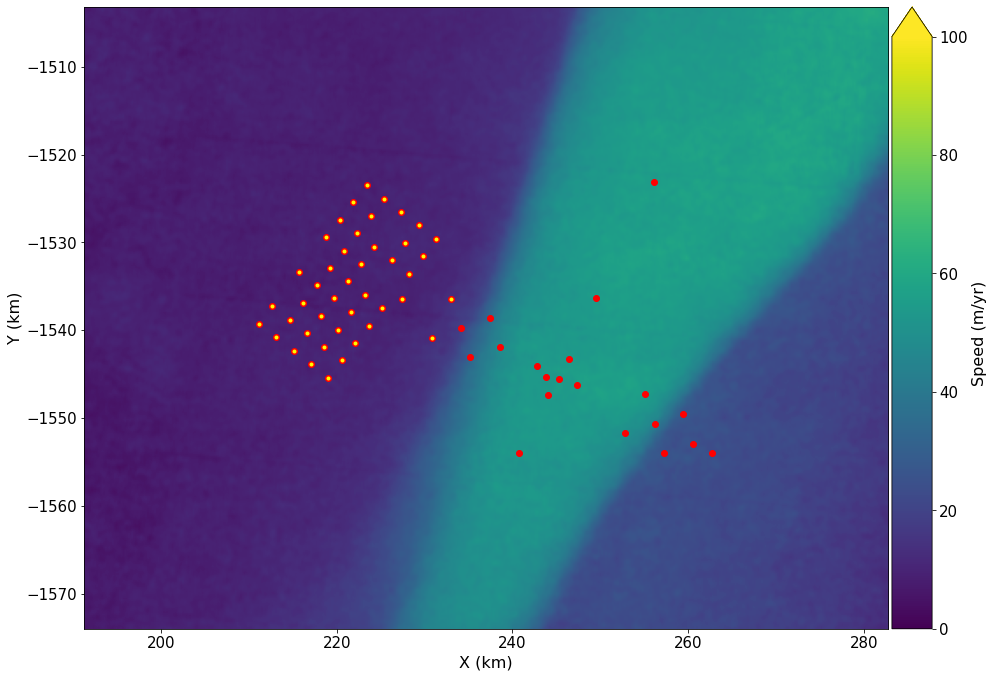

In [72]:
fig, ax = myVelRemote.displayVel()
myCVPts.plotAllCVLocs(ax=ax, color='red', marker='o')  # Show all points
myCVPts.plotVRangeCVLocs(0, 20, ax=ax, color='yellow') # Over plot slow points

## Interpolate Map to Cal/Val Points

In [73]:
vx20, vy20, iGood = myCVPts.vRangeData(myVelRemote, 0, 20)  # Values less than 20
vx, vy, iGood = myCVPts.vAllData(myVelRemote)  # All values

# Evaluate Data

Differences between the cal/val points ($v_x$ and $v_y$) and the points interpolated from the velocity map ($u_x$ and $u_y$) can be displayed as point plots and histograms as follows:

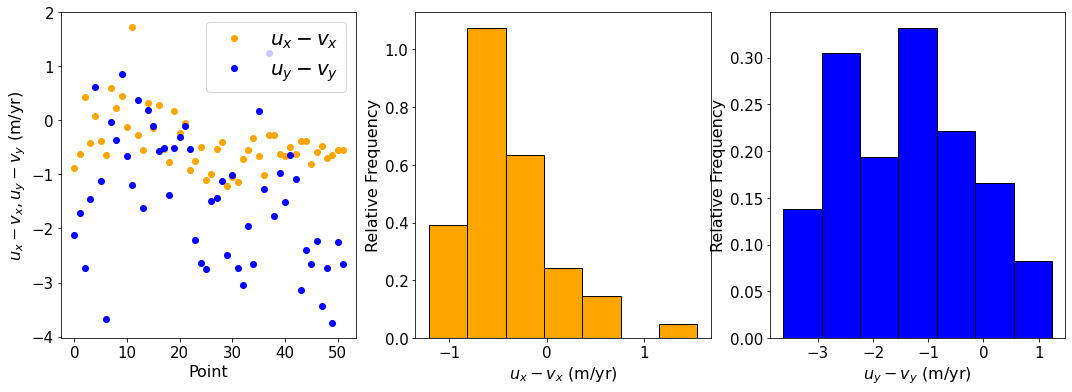

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axPoints = myCVPts.plotVRangeCVDiffs(myVelRemote, 0, 50, ax=axes[0], xColor='orange', marker='o', legendKwargs={'loc': 'upper right', 'fontsize': 20})
axesH = myCVPts.plotVRangeHistDiffs(myVelRemote, 0, 50, xColor='orange', axes=axes[1:], bins=7)